In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model


from env_test import GridEnvironment
from DQL_agent import DQNAgent
from DQL_agent_noreplay import DQNAgent_nr

In [2]:
# Load data
N = 10 # 10 EVs

# Get demand data
# TODO get apparent power from real and reactive, use just real for now
with open('Building Load Data/real_power_data.json', 'r') as json_file:
    real_dict = json.load(json_file)
    for key in real_dict.keys(): # get data from first key only (CAPTL_WF)
        demand_data = np.array(real_dict[key])
        break

# Get solar data
with open('PV Generation Data/pv_data.json', 'r') as json_file:
    pv_dict = json.load(json_file)
    for key in pv_dict.keys(): # get data from first key only (CAPTL_WF)
        solar_data = np.array(pv_dict[key])
        break

# Get wind data
with open('Wind Data/wind_data.json', 'r') as json_file:
    wind_dict = json.load(json_file)
    for key in wind_dict.keys(): # get data from first key only (CAPTL_WF)
        wind_data = np.array(wind_dict[key])
        break

In [3]:
#Quick fix for scaling Data
demand_data=demand_data/300
wind_data=wind_data*10

In [4]:
# Initialize environment with your chosen day's data

day_index=19 #random
timestep_length=.25 #in hours
batch_size = 10 #TWEAk
env = GridEnvironment(N, demand_data, solar_data, wind_data, day_index, timestep_length)

# Initialize DQN agent
agent = DQNAgent(state_size=env.state_size, action_size=env.action_size)

# Run for one episode (one day)
state = env.get_state()  # Reset environment to start state
total_reward = 0

T=96 #(15 minute steps in 24 hrs)

demand_profile = np.zeros(T)
solar_profile = np.zeros(T)
wind_profile = np.zeros(T)
PEV_profile = np.zeros(T)

for timestep in range(1, T+1):  # Assume T timesteps in a day
    action = agent.act(state)  # Decide action based on current state

    reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)

    demand_profile[timestep - 1] = next_demand
    solar_profile[timestep - 1] = next_solar
    wind_profile[timestep - 1] = next_wind
    PEV_profile[timestep - 1] = np.sum(next_P_EV)

    # Construct the new state from the separated components
    next_state = np.concatenate([
        np.array([next_demand, next_solar, next_wind]),  # Assuming these are scalar values
        np.array(next_P_EV)  # Assuming this is already an array or list
    ])
    
    agent.remember(state, action, reward, next_state, done)  # Store experience
    
    if done:
        print(f"Episode finished after {timestep} timesteps with total reward {total_reward}")  # This should be the point where the loop exits if the episode is done

    #Replay not working?\
    if len(agent.memory) >= batch_size:
       agent.replay(batch_size) # Train the agent with a minibatch from memory

    state = next_state  # Move to the next state
    total_reward += reward

print("Total reward for the episode (day):", total_reward)


Shape of state before predict: (1, 1, 13)
Shape of next_state before predict: (1, 13)
1/1 [==============================] - 0s 28ms/step


2024-04-11 21:09:49.213765: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


IndexError: index 42016 is out of bounds for axis 0 with size 1

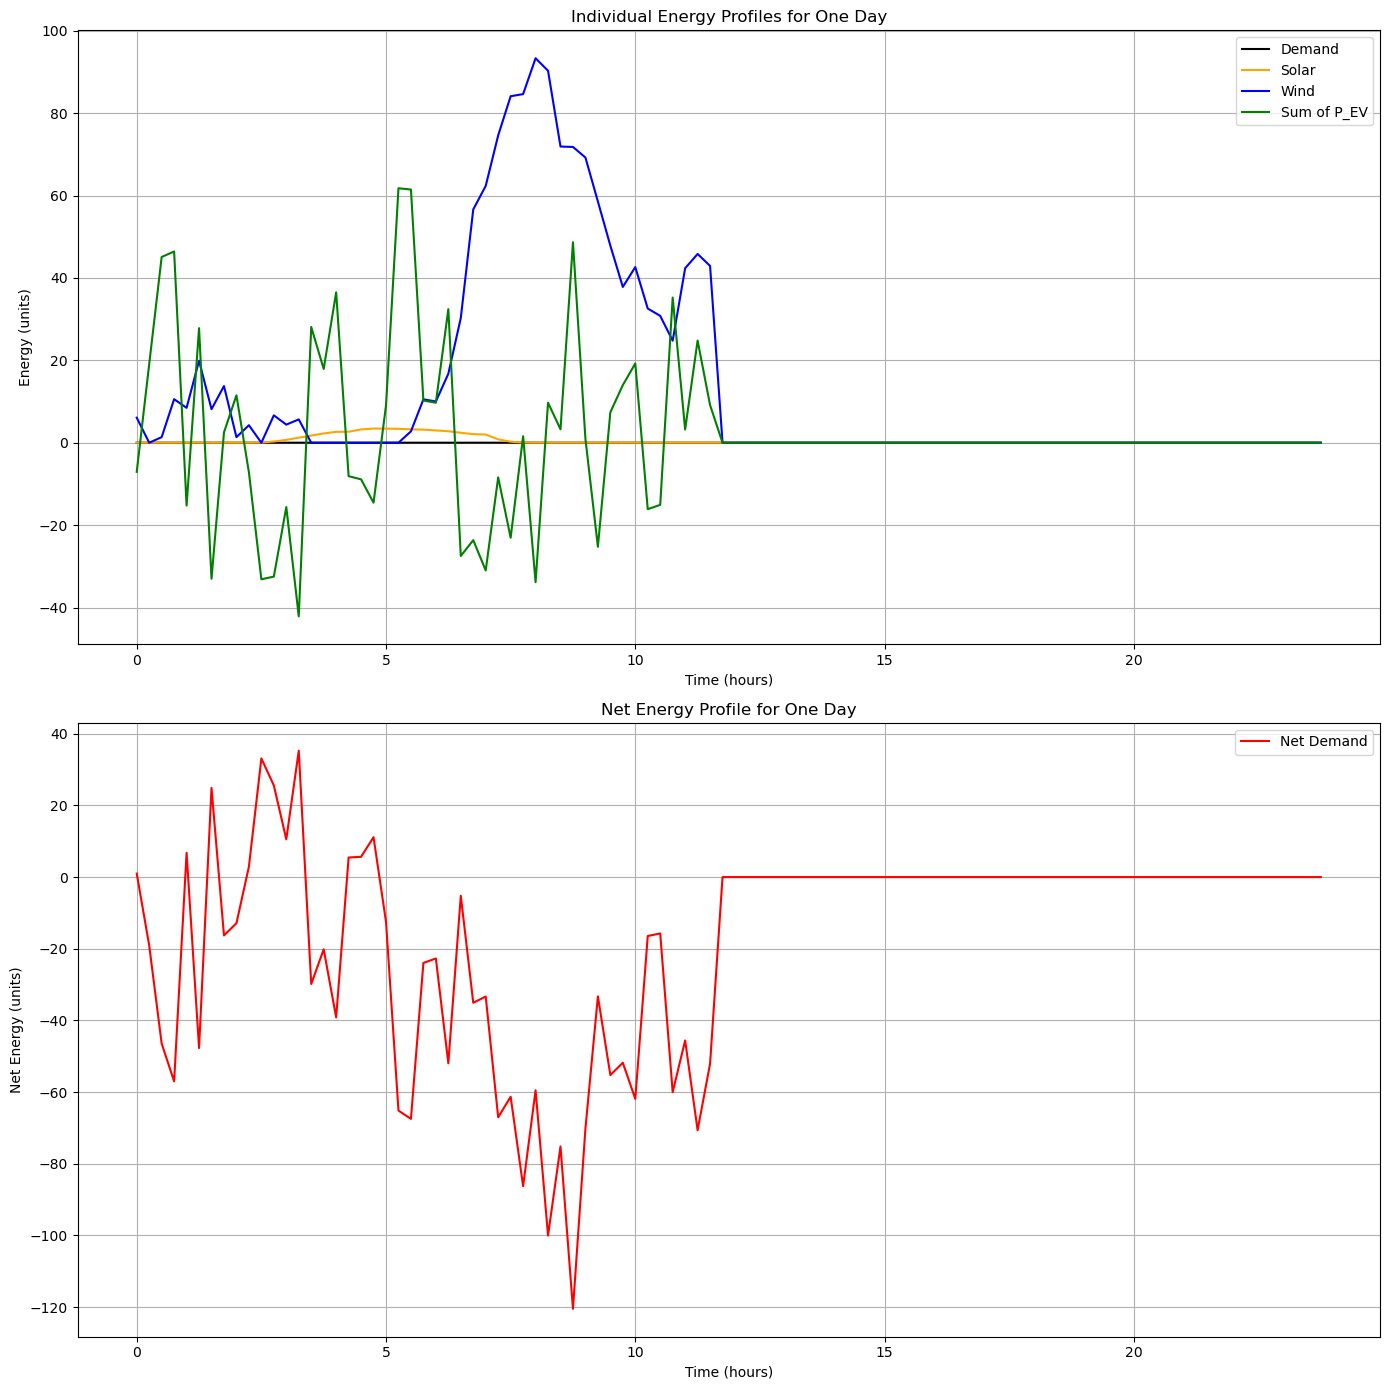

In [ ]:
#Plot Episode

time_steps = np.arange(0, T * timestep_length, timestep_length)  # Generate a time axis

plt.figure(figsize=(14, 14))  # Increase the figure size to accommodate two subplots

# First subplot for individual profiles
plt.subplot(2, 1, 1)  # (rows, columns, panel number)
plt.plot(time_steps, demand_profile, label='Demand', color='black')
plt.plot(time_steps, solar_profile, label='Solar', color='orange')
plt.plot(time_steps, wind_profile, label='Wind', color='blue')
plt.plot(time_steps, PEV_profile, label='Sum of P_EV', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (units)')
plt.title('Individual Energy Profiles for One Day')
plt.legend()
plt.grid(True)

# Second subplot for net demand
plt.subplot(2, 1, 2)  # (rows, columns, panel number)
net_demand_profile = demand_profile - solar_profile - wind_profile-PEV_profile
plt.plot(time_steps, net_demand_profile, label='Net Demand', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Net Energy (units)')
plt.title('Net Energy Profile for One Day')
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure
plt.show()

In [ ]:
#Attempt to loop through multiple episodes

demand_data=demand_data/300
wind_data=wind_data/10

day_index=0 
timestep_length=.25 #in hours
batch_size = 32 #TWEAk
env = GridEnvironment(N, demand_data, solar_data, wind_data, day_index, timestep_length)

# Initialize DQN agent
agent = DQNAgent(state_size=env.state_size, action_size=env.action_size)

# Run for one episode (one day)
state = env.get_state()  # Reset environment to start state
total_reward = 0

T=96 #(15 minute steps in 24 hrs)

demand_profile = np.zeros(T)
solar_profile = np.zeros(T)
wind_profile = np.zeros(T)
PEV_profile = np.zeros(T)

for episode in range(400):  # Simulate 100 days
    day_index = episode  # Update day index for each episode
    env = GridEnvironment(N, demand_data, solar_data, wind_data, day_index, timestep_length)
    
    state = env.get_state()
    total_reward = 0
    
    # Arrays to store profiles for the day
    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)

    for timestep in range(1, T+1):
        action = agent.act(state)
        reward, done, next_demand, next_solar, next_wind, next_P_EV = env.step(action)
        
        # Update profiles
        demand_profile[timestep - 1] = next_demand
        solar_profile[timestep - 1] = next_solar
        wind_profile[timestep - 1] = next_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)
        testPEV= next_P_EV

        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), np.array(next_P_EV)])
        
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state
        total_reward += reward

        if done:
            print(testPEV)
            break

    print(f"Episode {episode+1} finished with total reward {total_reward}")
    # Optionally: agent.replay(batch_size) here if you want to train after each episode


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 1 finished with total reward -0.23583093333333316
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 2 finished with total reward -0.24750186666666665
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 3 finished with total reward -8.526919328000002
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 4 finished with total reward -20.118916938666683
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 5 finished with total reward -14.16419606933332
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 6 finished with total reward -4.850422074666667
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 7 finished with total reward -0.20159093333333356
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 8 finished with total reward -21.32549540799999
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 9 finished with total reward -9.527969205333335
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 10 finished with total reward -10.856771941333331
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Episode 11 finished with total reward -0.15804106666666667
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


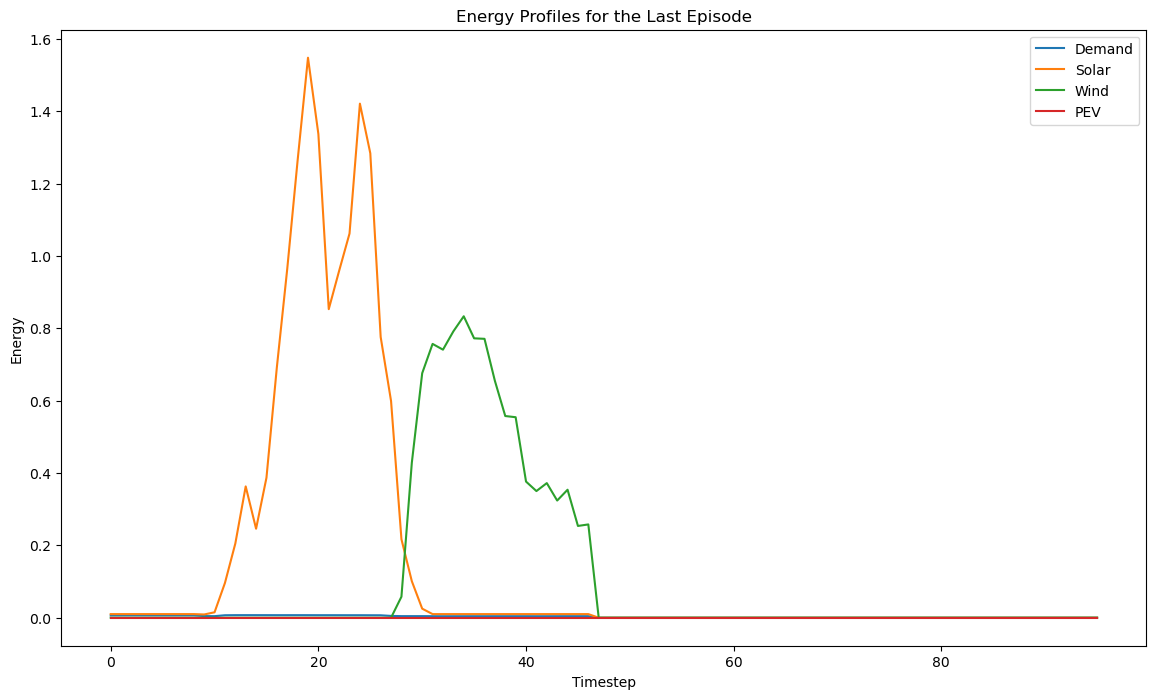

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand')
plt.plot(solar_profile, label='Solar')
plt.plot(wind_profile, label='Wind')
plt.plot(PEV_profile, label='PEV')
plt.legend()
plt.title('Energy Profiles for the Last Episode')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()